In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('M2SLMoneyStock.csv', index_col = 0, parse_dates =True)
df.index.freq = 'MS'

sp = pd.read_csv('PCEPersonalSpending.csv', index_col = 0, parse_dates = True)
sp.index.freq = 'MS'

In [ ]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [ ]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [ ]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


<Axes: xlabel='Date'>

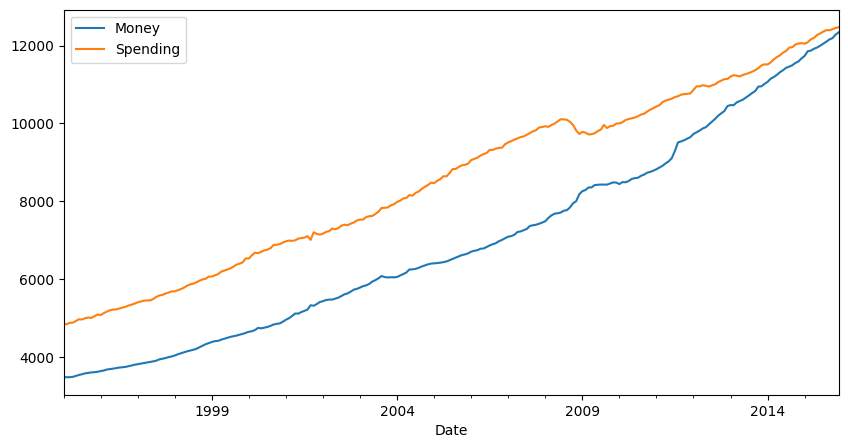

In [ ]:
df.plot(figsize = (10,5))

##Checking for Stationarity

In [ ]:
#Our own ADF function

def adf_test(series, title=''):
  """
  Pass in a time series, returns an ADF Report
  """
  print(f'Augmented Dickey Fuller Test: {title}')
  result = adfuller(series.dropna(), autolag = 'AIC')

  labels = ['ADF Test Statistic', 'p-value', '# lags used', '# observations']
  out = pd.Series(result[0:4], index =labels)

  for key,val in result[4].items():
    out[f'critical value ({key})'] = val

  print(out.to_string())

  if result[1] <= 0.05:
    print('Strong evidence against the null hypothesis')
    print('Reject the null hypothesis')
    print('Data has no unit root and is stationary')

  else:
    print('Weak evidence against the null hypothesis')
    print('Fail to reject the null hypothesis')
    print('Data has unit root and is not-stationary')

In [ ]:
adf_test(df['Money'])

Augmented Dickey Fuller Test: 
ADF Test Statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has unit root and is not-stationary


In [ ]:
adf_test(df['Spending']) #Neither variables are stationary

Augmented Dickey Fuller Test: 
ADF Test Statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has unit root and is not-stationary


In [ ]:
df_transformed = df.diff()

In [ ]:
adf_test(df_transformed['Money']) #Still Non Stationary after 1st differencing

Augmented Dickey Fuller Test: 
ADF Test Statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has unit root and is not-stationary


In [ ]:
adf_test(df_transformed['Spending']) #Stationary

Augmented Dickey Fuller Test: 
ADF Test Statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
df_transformed = df_transformed.diff()

In [ ]:
adf_test(df_transformed['Money'])

Augmented Dickey Fuller Test: 
ADF Test Statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
 df_transformed.dropna(inplace =True)

In [ ]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


#Train Test Split

In [ ]:
#No. of Observations
nobs = 12

train =df_transformed[:-nobs]
test = df_transformed[-nobs:]

#GRID SEARCH FOR ORDER OF VAR MODEL

In [ ]:
model = VAR(train)

for p in range(1,8):
  result = model.fit(p)
  print(f'Order: {p}')
  print(f'AIC: {result.aic}')
  print('\n')

Order: 1
AIC: 14.178610495220896


Order: 2
AIC: 13.955189367163705


Order: 3
AIC: 13.849518291541038


Order: 4
AIC: 13.827950574458281


Order: 5
AIC: 13.787300344609642


Order: 6
AIC: 13.799076756885807


Order: 7
AIC: 13.797638727913972




In [ ]:
result = model.fit(5)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, Feb, 2024
Time:                     06:52:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

#Forecasting

In [ ]:
#Grab 5 lagged values right before the test set starts
#Numpy array

train.values[-5:]

array([[-31.9,  40.3],
       [  5.6, -70.7],
       [ 25.5,  52.5],
       [-21.3, -37.2],
       [ 39.5, -17.8]])

In [ ]:
z = result.forecast(y = train.values[-5:], steps = 12)

In [ ]:
idx = pd.date_range('2015-01-01', periods =12, freq ='MS')

In [ ]:
df_forecast = pd.DataFrame(data =z, index =idx, columns = ['Money_2d','Spending_2d' ])

#Invert the Transformation

In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [ ]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [ ]:
test_range = df[-nobs:]
test_range.head()

,Money,Spending
Date,,
2015-01-01,11733.2,12046.0
2015-02-01,11852.4,12082.4
2015-03-01,11868.8,12158.3
2015-04-01,11916.1,12193.8
2015-05-01,11947.6,12268.1


<Axes: xlabel='Date'>

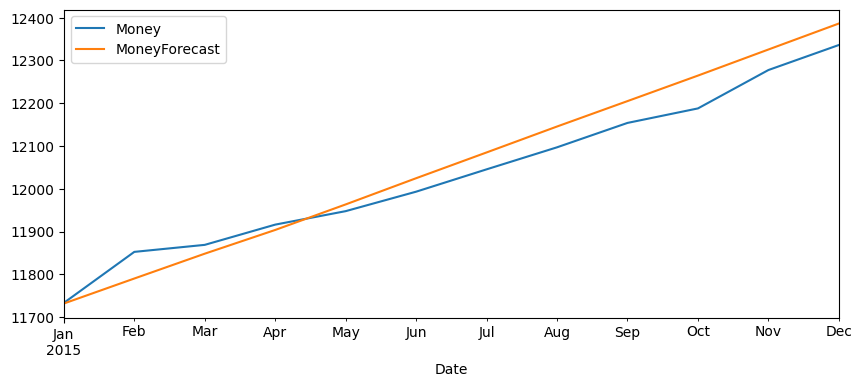

In [ ]:
test_range['Money'].plot(figsize = (10, 4), legend = True)
df_forecast['MoneyForecast'].plot(legend =True)

<Axes: xlabel='Date'>

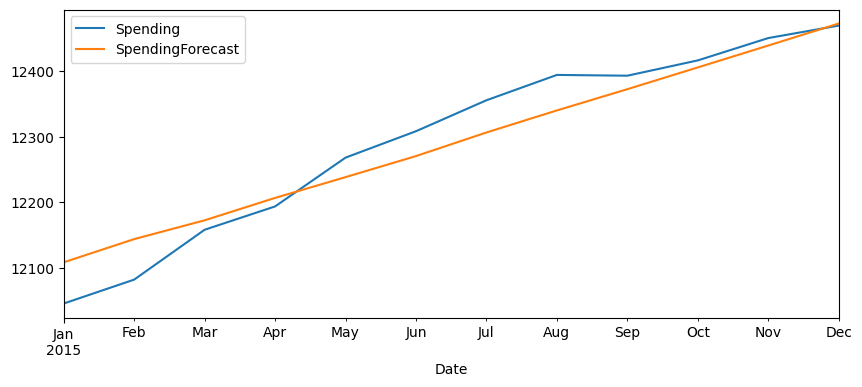

In [ ]:
test_range['Spending'].plot(figsize = (10,4), legend = True)
df_forecast['SpendingForecast'].plot(legend = True)

In [ ]:
rmse(test_range['Money'], df_forecast['MoneyForecast'])

43.71049653558875

In [ ]:
rmse(test_range['Spending'], df_forecast['SpendingForecast'])

37.00117516940808

#Using Varmax with autoarima

In [ ]:
auto_arima(df['Money'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
auto_arima(df['Spending'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
df_transformed.head() #Already 2nd differenced

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


#Fit the VARMA(1,2) Model

In [ ]:
model = VARMAX(train, order = (1,2))
results = model.fit(maxiter =1000, disp = False)
print(results.summary())

                             Statespace Model Results                            
Dep. Variable:     ['Money', 'Spending']   No. Observations:                  238
Model:                        VARMA(1,2)   Log Likelihood               -2286.252
                             + intercept   AIC                           4606.503
Date:                   Sat, 03 Feb 2024   BIC                           4665.532
Time:                           06:53:27   HQIC                          4630.293
Sample:                       03-01-1995                                         
                            - 12-01-2014                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             1.09, 0.00   Jarque-Bera (JB):       524.12, 105.46
Prob(Q):                        0.30, 0.97   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.35, 3.03   Skew:                      1.30, -0.32
Prob(H) (t

In [ ]:
#Forecasting is simpler in case of VARMAX, we don't need to provide the previous observations.
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-9.315895,35.188437
2015-02-01,-9.977139,-2.678072
2015-03-01,-0.502798,-0.528719
2015-04-01,-1.152068,-0.258689
2015-05-01,0.297176,0.004812
2015-06-01,-0.021861,0.002008
2015-07-01,0.234190,0.039929
2015-08-01,0.148758,0.033599
2015-09-01,0.198543,0.039983
2015-10-01,0.178604,0.038084


#Invert the Transformation

In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

#Plotting the Results

<Axes: xlabel='Date'>

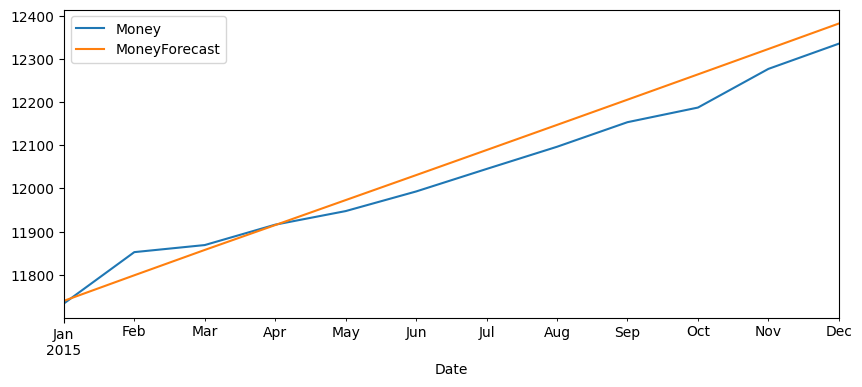

In [ ]:
df['Money'][-nobs:].plot(figsize =(10,4), legend =True).autoscale(axis ='x', tight =True)
df_forecast['MoneyForecast'].plot(legend = True)

<Axes: xlabel='Date'>

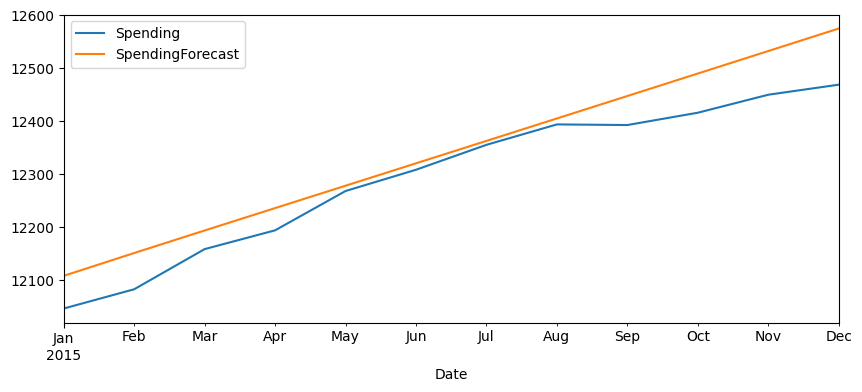

In [ ]:
df['Spending'][-nobs:].plot(figsize =(10,4), legend =True).autoscale(axis ='x', tight =True)
df_forecast['SpendingForecast'].plot(legend = True)

In [ ]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
RMSE1

43.40153209155376

In [ ]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
RMSE2

56.65888578512296